In [ ]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
data = pd.read_csv('/content/drive/MyDrive/news_tweets_cleaned_2.csv',encoding='latin1')
selected_columns = data[["Tweet_english"]]
#df_full=data['Tweet_english']
df = selected_columns.copy()
df.drop(df[df['Tweet_english'].str.startswith('RT')].index,inplace = True)
#df=data['Text']
#print (f'Document: {df.iloc[0]}')
#df=df_full.head(105)
print(df)
tweet_list=list(df['Tweet_english'])
print(len(tweet_list))
print("df_sample Created")

                                          Tweet_english
0     australia nears omicron peak as daily infectio...
1     indias covid vaccination coverage crosses  crore 
2      covid delhi records  cases  deaths testing low  
3     covid  west bengal registers  fresh cases amp ...
4     corona is a unique virus as it has a very high...
...                                                 ...
2007  worldbank suspends funding of projects in afgh...
2008  g leaders issued joint statement on afghanista...
2009  weve helped evacuate  people from afghanistan ...
2010  key face of antitaliban axis issues a warning ...
2011  newsalert  taliban panel meets chinese envoy t...

[2012 rows x 1 columns]
2012
df_sample Created


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from numpy import around
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
vectorizer=TfidfVectorizer(max_features=100)
vectorizer.fit(df.Tweet_english)
result=vectorizer.transform(df.Tweet_english)
result=result.toarray()



Type of df -  <class 'pandas.core.frame.DataFrame'>
Type of Result -  <class 'numpy.ndarray'>
Shape of df -  (2012, 1)
Done
Size of result -  (2012, 100)
Size of pairwise similarities -  (2012, 2012)


In [ ]:
from keras.preprocessing.text import Tokenizer
import gensim
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df.Tweet_english)
tokenized_documents=tokenizer.texts_to_sequences(df.Tweet_english)
tokenized_paded_documents=pad_sequences(tokenized_documents,maxlen=20,padding='post')
vocab_size=len(tokenizer.word_index)+1
print (tokenized_paded_documents[1])
print(len(tokenized_paded_documents[1]))

[  58    9  296 1627 1226  816    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
20


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2022-01-23 03:35:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-23 03:35:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-23 03:35:44--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [ ]:
embeddings_index = dict()

with open('glove.6B.100d.txt') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    

In [ ]:
embedding_matrix_glove=np.zeros((vocab_size,100))

for word,i in tokenizer.word_index.items():
    embedding_vector_glove = embeddings_index.get(word)
    if embedding_vector_glove is not None:
        embedding_matrix_glove[i] = embedding_vector_glove

In [ ]:
document_embeddings_glove=np.zeros((len(tokenized_paded_documents),100))
words=vectorizer.get_feature_names()

for i in range(df.shape[0]):
    for j in range(len(words)):
        document_embeddings_glove[i]+=embedding_matrix_glove[tokenizer.word_index[words[j]]]*result[i][j]
        
document_embeddings_glove=document_embeddings_glove/np.sum(result,axis=1).reshape(-1,1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
document_embeddings_glove.shape

(2012, 100)

In [ ]:
print(np.any(np.isnan(document_embeddings_glove)))
document_embeddings_glove = np.nan_to_num(document_embeddings_glove)
print(np.any(np.isnan(document_embeddings_glove)))

False
False


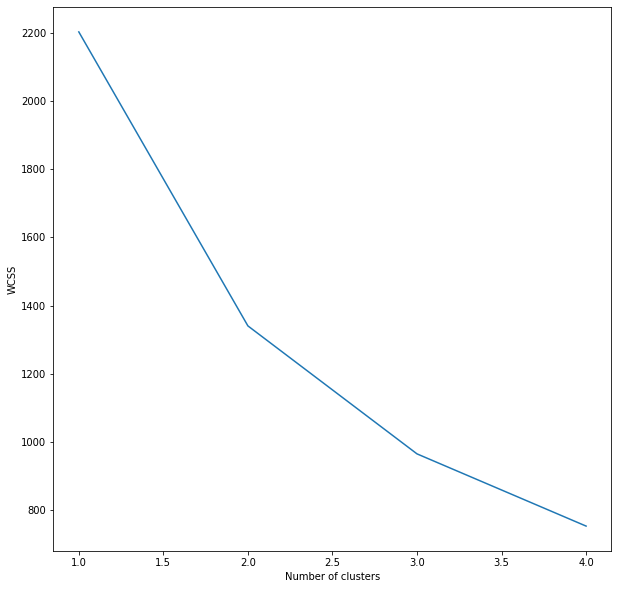

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
wcss = []
pca = PCA(2)
data = pca.fit_transform(document_embeddings_glove)
for i in range(1,5):
   model = KMeans(n_clusters = i, init = "k-means++")
   #model.fit(document_embeddings_glove)
   model.fit(data)
   wcss.append(model.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,5), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
pca = PCA(2)
data = pca.fit_transform(document_embeddings_glove)

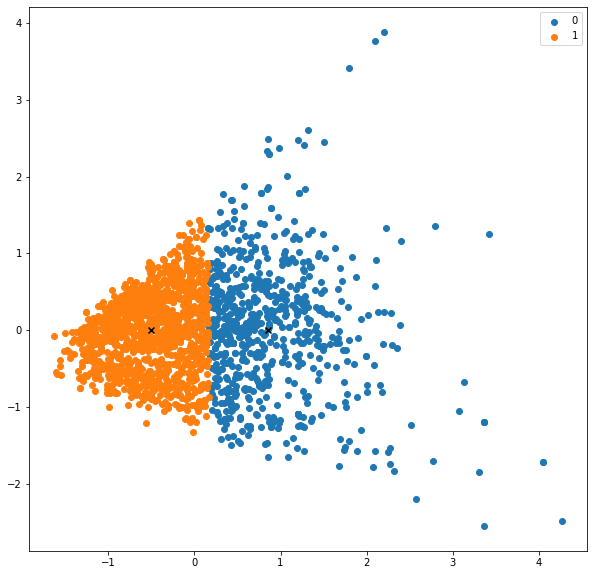

In [ ]:
centers = np.array(model.cluster_centers_)
model = KMeans(n_clusters = 2, init = "k-means++")
label = model.fit_predict(data)
#print(label)
plt.figure(figsize=(10,10))
uniq = np.unique(label)
for i in uniq:
   plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
#This is done to find the centroid for each clusters.
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
score = silhouette_score(data, label)
print("silhouette score is {})".format(round(score,2)))
print("DB Score: %0.3f"
      % davies_bouldin_score(data, label))

silhouette score is 0.39)
DB Score: 1.073


In [ ]:
cluster_df=pd.DataFrame(list(zip(tweet_list, label)),
              columns=['Tweet','Cluster'])
cluster_df.to_csv("tweet_cluster_glove.csv")